# Segmentación

OpenCV 3.x with Python By Example - Second Edition - (Cap. 8) Detecting Shapes and Segmenting an Image
https://learning.oreilly.com/library/view/opencv-3x-with/9781788396905/6983ef57-ae81-40d6-a3e9-4b30aa8a4dfd.xhtml

Computer Vision with Python 3 - (Cap. 4) Segmentation - Understanding Images Better
https://learning.oreilly.com/library/view/computer-vision-with/9781788299763/b4f6672b-7146-435b-ba67-310825e22654.xhtml

https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html

In [2]:
import numpy as np  
import cv2 

import matplotlib.pyplot as plt
import plot_cv_utils

%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.5)

## Extracción de contornos

https://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html

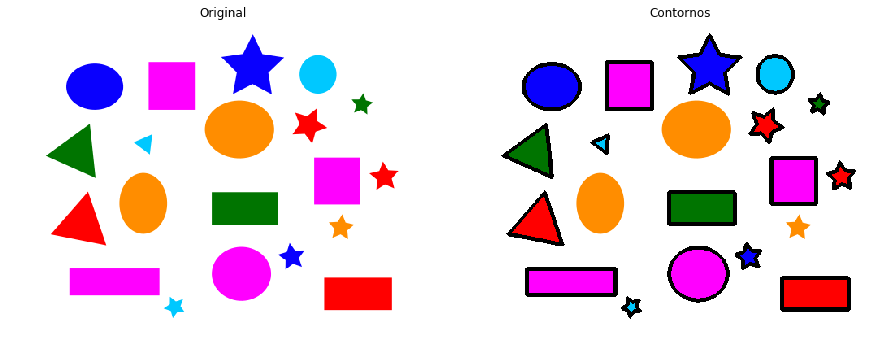

Objetos 17


In [3]:
# Hay 20 objetos
umbral = 150 # con 160 salen todos
img_objs = cv2.imread('images/objetos.png')
img_objs_gray = cv2.cvtColor(img_objs, cv2.COLOR_BGR2GRAY)

# con THRESH_BINARY_INV el fondo queda negro así no
# aparece como contorno el borde de imagen
ret, thresh = cv2.threshold(img_objs_gray, umbral, 255,
                            cv2.THRESH_BINARY_INV)

img_contours, contours, hierarchy = cv2.findContours(thresh,
                        cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_contours2 = cv2.drawContours(img_objs.copy(), contours,
                                 -1, (0, 0, 0), 3)

plot_cv_utils.subplot_cv_list([img_objs, img_contours2], 
                              ['Original', 'Contornos'], False, False)

# Número total de objetos ¿?
print("Objetos {}".format(len(contours))) 

### Actividad

Extraer los contornos de figures/monedas.jpg.
Ahora la figura el fondo no es blanco uniforme ni los colores de las monedas son uniformes debido a las diferencias de iluminación. Pueden ser necesario suavizados, operaciones morfológicas, uso de umbralización adaptativa, etc. Puede haber distintas soluciones válidas.

### Watershed

Adaptado de https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html

Se emplean los siguientes métodos de OpenCV:

distanceTransform() https://docs.opencv.org/master/d7/d1b/group__imgproc__misc.html#ga8a0b7fdfcb7a13dde018988ba3a43042

connectedComponents()
https://docs.opencv.org/master/d3/dc0/group__imgproc__shape.html#gaedef8c7340499ca391d459122e51bef5

watershed()
https://docs.opencv.org/master/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1

#### Motivación

Si ahora usamos figures/monedas2.jpg nos encontramos con que hay monedas unidas por lo que será más difícil encontrar los contornos de cada una y poder contarlas, salen 6 contornos.

<img src="figures/monedas2_contornos.jpg" width="400">

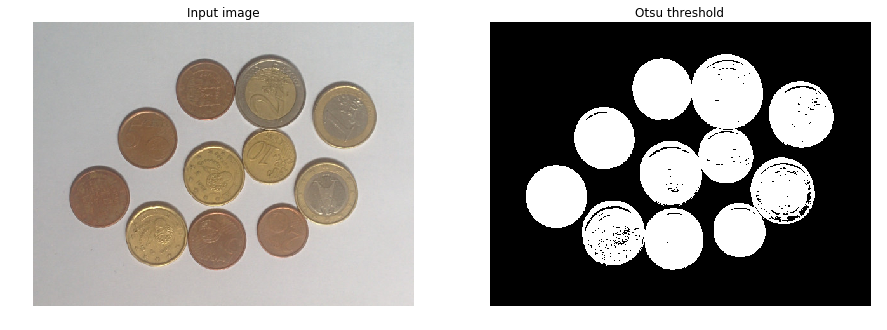

In [4]:
img_coins2 = cv2.imread('images/monedas2.jpg')
img_coins2_gray = cv2.cvtColor(img_coins2,cv2.COLOR_BGR2GRAY)
ret, thresh2 = cv2.threshold(img_coins2_gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plot_cv_utils.subplot_cv_list([cv2.cvtColor(img_coins2, cv2.COLOR_BGR2RGB), thresh2], 
                              ['Input image', 'Otsu threshold'], False, True)

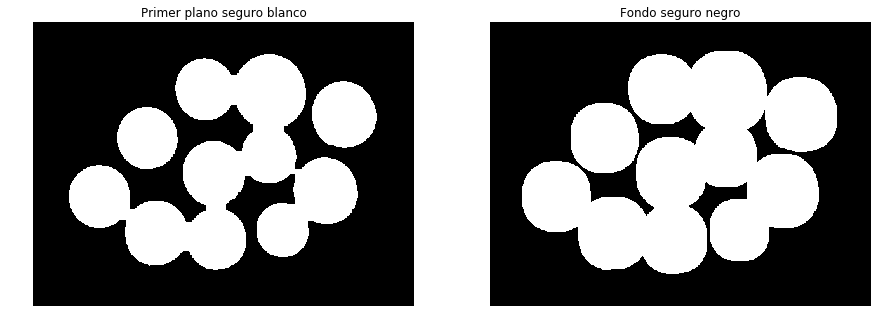

In [5]:
# noise removal
kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(thresh2,cv2.MORPH_CLOSE,kernel,
                           iterations = 2)
# sure background area
sure_bg = cv2.dilate(closing,kernel,iterations=3)

plot_cv_utils.subplot_cv_list([closing, sure_bg], 
                              ['Primer plano seguro blanco', 'Fondo seguro negro'],
                              False, True)

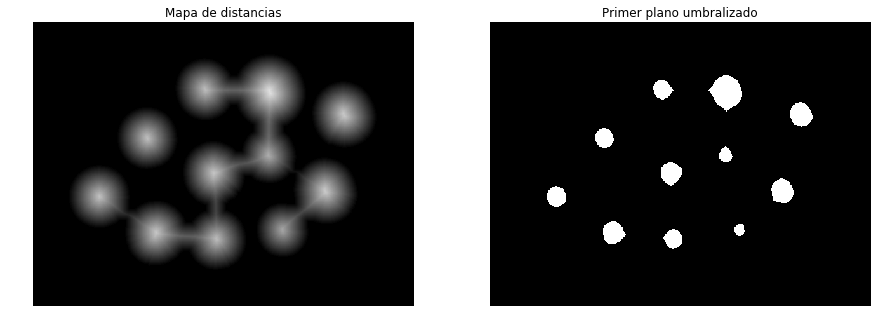

In [6]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(closing,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.6*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# multiplicamos por factor para que se vea más claro
factor = 255//np.amax(dist_transform)
plot_cv_utils.subplot_cv_list([dist_transform*4, sure_fg], 
                              ['Mapa de distancias', 'Primer plano umbralizado'],
                              False, True)

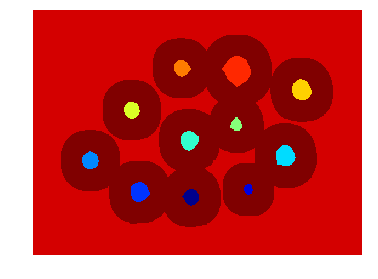

Monedas 11


In [7]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

# Lo siguiente es solo para obtener la imagen siguiente no para la segmentación
# applyColorMap necesita uint8
markers_u8 = markers.astype(np.uint8)
# multiplicamos por factor para que se vea más claro
factor = 255//np.amax(markers_u8)
markers_jet = cv2.applyColorMap(markers_u8*factor, cv2.COLORMAP_JET)

# Rojo el fondo seguro, rojo oscuro zona desconocida, otros colores primer plano seguro
plot_cv_utils.plot_cv_img(markers_jet, True)

# Número total de monedas ¿?
# -1 por el fondo
print("Monedas {}".format(ret - 1))

(447, 600)


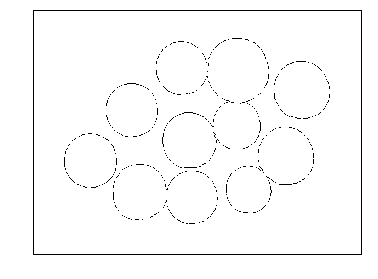

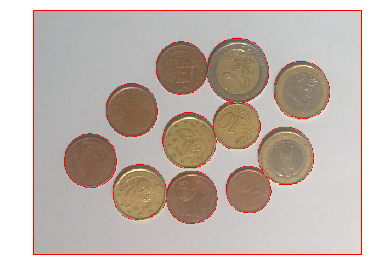

In [8]:
# Aplicamos watershed
img_final = img_coins2.copy()
markers = cv2.watershed(img_final, markers)
img_final[markers == -1] = [0,0,255]

print(markers.shape)
plot_cv_utils.plot_cv_img(markers*255, True)
plot_cv_utils.plot_cv_img(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB),
                          True)


## Buscando formas

Utiliza el método de OpenCv matchShapes(), basado en los momentos (media, varianza, etc.) de la formas encontradas en la imagen y las formas a buscar https://docs.opencv.org/master/d3/dc0/group__imgproc__shape.html#gaadc90cb16e2362c9bd6e7363e6e4c317

Adaptado de OpenCV 3.x with Python By Example - Second Edition para usar plot_cv_utils
https://learning.oreilly.com/library/view/opencv-3x-with/9781788396905/e2386d1e-089d-4609-9290-247acf8cd288.xhtml

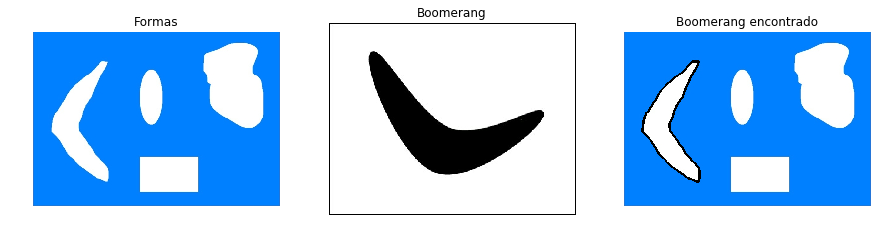

In [9]:
import sys

# Extract reference contour from the image
def get_ref_contour(img):
    ref_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(ref_gray, 127, 255, 0)

    # Find all the contours in the thresholded image. The values
    # for the second and third parameters are restricted to a 
    # certain number of possible values. You can learn more 
    # 'findContours' function here: 
    # http://docs.opencv.org/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html
    img_contours, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,
                                            cv2.CHAIN_APPROX_SIMPLE)

    # Extract the relevant contour based on area ratio. We use the 
    # area ratio because the main image boundary contour is 
    # extracted as well and we don't want that. This area ratio 
    # threshold will ensure that we only take the contour inside 
    # the image.
    for contour in contours:
        area = cv2.contourArea(contour)
        img_area = img.shape[0] * img.shape[1]
        if 0.05 < area/float(img_area) < 0.8:
            return contour

# Extract all the contours from the image
def get_all_contours(img):
    ref_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(ref_gray, 127, 255, 0)
    img_contours, contours, hierarchy = cv2.findContours(thresh, 1, 2)
    return contours

# Boomerang reference image
img1 = cv2.imread('images/boomerang.jpeg')

# Input image containing all the different shapes
img2 = cv2.imread('images/shapes.jpeg')

# Extract the reference contour
ref_contour = get_ref_contour(img1)

# Extract all the contours from the input image
input_contours = get_all_contours(img2)

closest_contour = input_contours[0]
min_dist = sys.maxsize
# Finding the closest contour
for contour in input_contours:
    # Matching the shapes and taking the closest one
    ret = cv2.matchShapes(ref_contour, contour, 1, 0.0)
    if ret < min_dist:
        min_dist = ret
        closest_contour = contour

img3 = img2.copy()
cv2.drawContours(img3, [closest_contour], -1, (0,0,0), 3)

plot_cv_utils.subplot_cv_list([cv2.cvtColor(img2, cv2.COLOR_BGR2RGB),
                img1, cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)],
                ['Formas', 'Boomerang', 'Boomerang encontrado'],
                False, True)